# Analyzing geolocation data that Google has gathered about me throughout the last 6 months, using Pandas, Geopandas and shapely libraries

### Imports

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely.geometry as sg
import datetime as dt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

### Code for json parsing with pandas

In [2]:
json_filepath = "./RecordsAliaksei.json"
json_df = pd.read_json(json_filepath)


def extract_activity(location: dict) -> str:
    try:
        return location["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"
    
    
def parse_json_df(json_df: pd.DataFrame) -> pd.DataFrame:
    """Create a GeoPandas DataFrame"""
    
    ## parse cordinates into shapely Points
    points = []
    for location in json_df.locations:
        x = location["longitudeE7"] / 10**7
        y = location["latitudeE7"] / 10**7
        xy = (x, y)
        points.append(sg.Point(xy))
        
        
    ## parse the rest of the json
    df = gpd.GeoDataFrame(geometry=points)
    #df["latitude"] = json_df.locations.apply(lambda x: x["latitudeE7"])
    #df["longitude"] = json_df.locations.apply(lambda x: x["longitudeE7"])
    df["timestamp"] = json_df.locations.apply(lambda x: pd.to_datetime(x["timestamp"]))
    df["accuracy"] = json_df.locations.apply(lambda x: x["accuracy"])
    df["velocity"] = json_df.locations.apply(lambda x: x.get("velocity", None))
    df["heading"] = json_df.locations.apply(lambda x: x.get("heading", None))
    df["altitude"] = json_df.locations.apply(lambda x: x.get("altitude", None))
    df["activity"] = json_df.locations.apply(extract_activity)
    return df


df = parse_json_df(json_df)

### Code for plotting the world and locations visited with geopandas and shapely

In [3]:
%%capture
world_shape_filepath = r"./TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp"
world = gpd.read_file(world_shape_filepath)

In [4]:
## set default matplotlib colormap
cmap = "viridis"
mpl.rc('image', cmap=cmap)


def draw_legend(df, ax, steps) -> None:
    """Plots a legend using a palette to assign colors to the timestamps"""
    
    ## Generate a "steps" number of value to pass to the colormap
    colormap_inputs = np.linspace(0, 1, 5)
    
    ## Create lines of according colors
    custom_lines = [Line2D([0], [0], color=cm.get_cmap(cmap)(step), lw=6) for step in colormap_inputs]
    
    ## labels from the timestamps
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in colormap_inputs]
    
    ## plot the legend
    ax.legend(custom_lines, labels, loc='lower right', handlelength=10)
    
    
def draw_map(df: gpd.GeoDataFrame, box, title = "") -> None:
    """Draw world map within the borders of the box, plotting the points in the df"""
    
    ## geodataframe containing only geometries inside the box geometry
    df = df.set_crs(world.crs.name)
    df_box = df[df.geometry.within(box)].sort_values("timestamp")
    
    ## borders for the plot
    min_x, min_y, max_x, max_y = box.bounds  # values are in degrees of longitude and latitude respectively
    
    ## plot the map
    width_inches = 16
    height_inches = 16
    base = world.plot(color='white', edgecolor='silver', figsize=(width_inches, height_inches))
    base.set_xlim(min_x, max_x)
    base.set_ylim(min_y, max_y)
    
    xlabel = f"longitude, {chr(176)}"
    ylabel = f"latitude, {chr(176)}"
    base.set_xlabel(xlabel, fontsize=15)
    base.set_ylabel(ylabel, fontsize=15)
    base.set_title(title, fontsize=20)
    
    
    ## choose a cmap for points
    cmap = cm.get_cmap('plasma')
    
    ## plot the visited locations
    # next lines are needed for colormapping
    #t = [mpl.dates.date2num(ts.to_pydatetime()) for ts in df.timestamp]  # not necessary?
    ax = df_box.plot(ax=base, marker='o', markersize=8, c=df.timestamp)
    
    ## legend and ticks
    draw_legend(df_box, ax, 5)
    tick_length_x = abs(max_x - min_x)  / 10
    tick_length_y = abs(max_y - min_y)  / 10
    plt.xticks(np.arange(min_x, max_x, tick_length_x))
    plt.yticks(np.arange(min_y, max_y, tick_length_y))
    
    ## saving
    plt.savefig(r"./figure.png")

# Locations visualized
## Worldwide


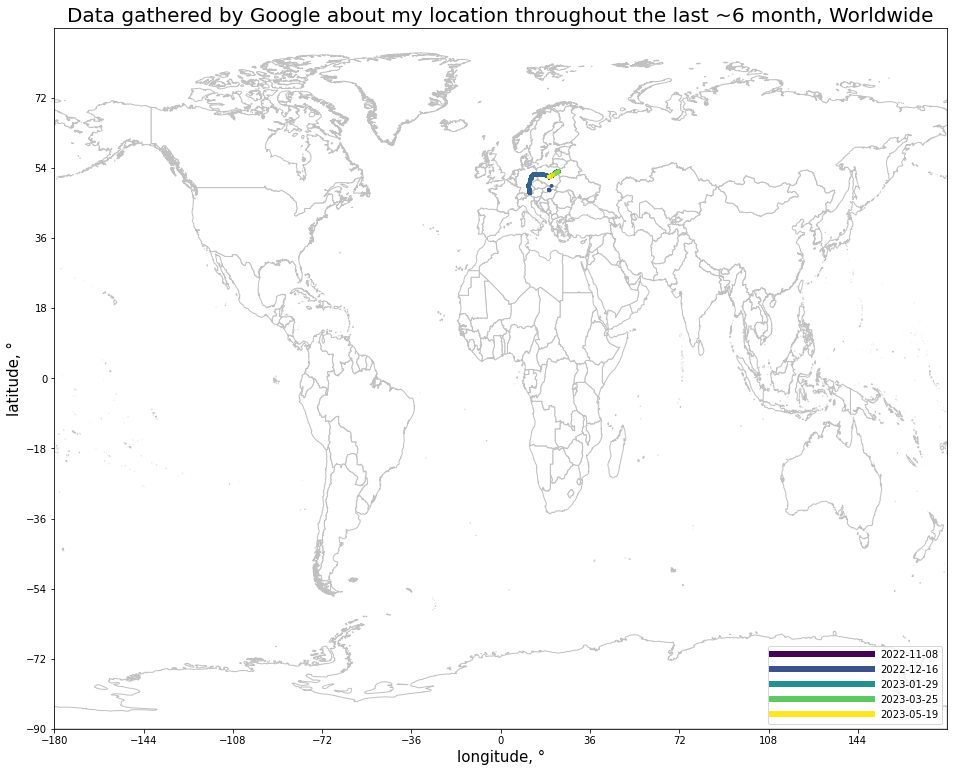

In [5]:
world_box = sg.box(-180, -90, 180, 90)
draw_map(df, world_box, "Data gathered by Google about my location throughout the last ~6 month, Worldwide")

## Europe

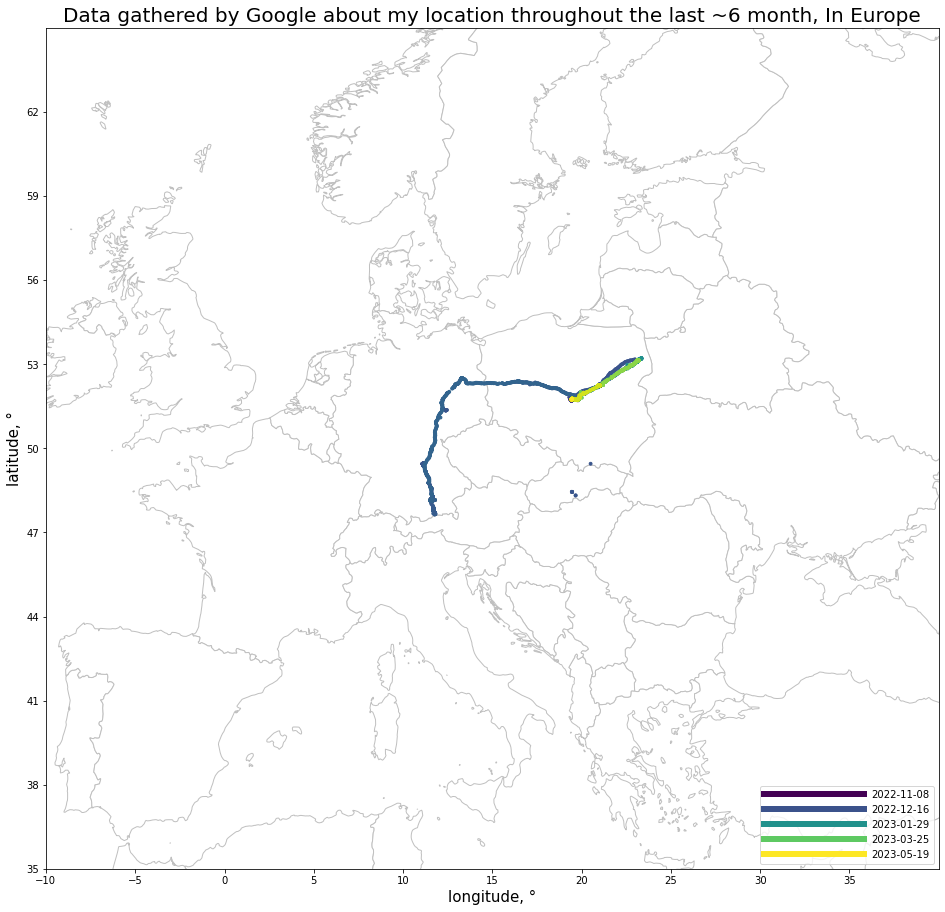

In [6]:
europe_box = sg.box(-10, 35, 40, 65)  # minlong, minlat, maxlong, maxlat
draw_map(df, europe_box, "Data gathered by Google about my location throughout the last ~6 month, In Europe")

## Poland


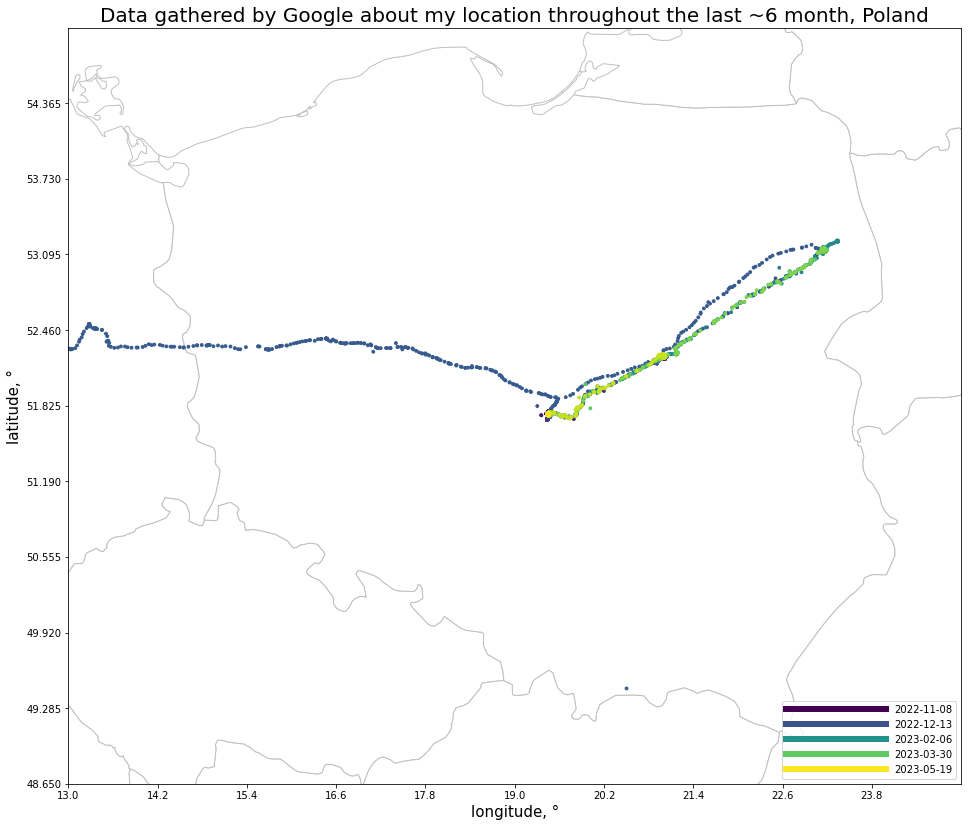

In [7]:
poland_box = sg.box(13, 48.65, 25, 55)
draw_map(df, poland_box, "Data gathered by Google about my location throughout the last ~6 month, Poland")

## Łódź

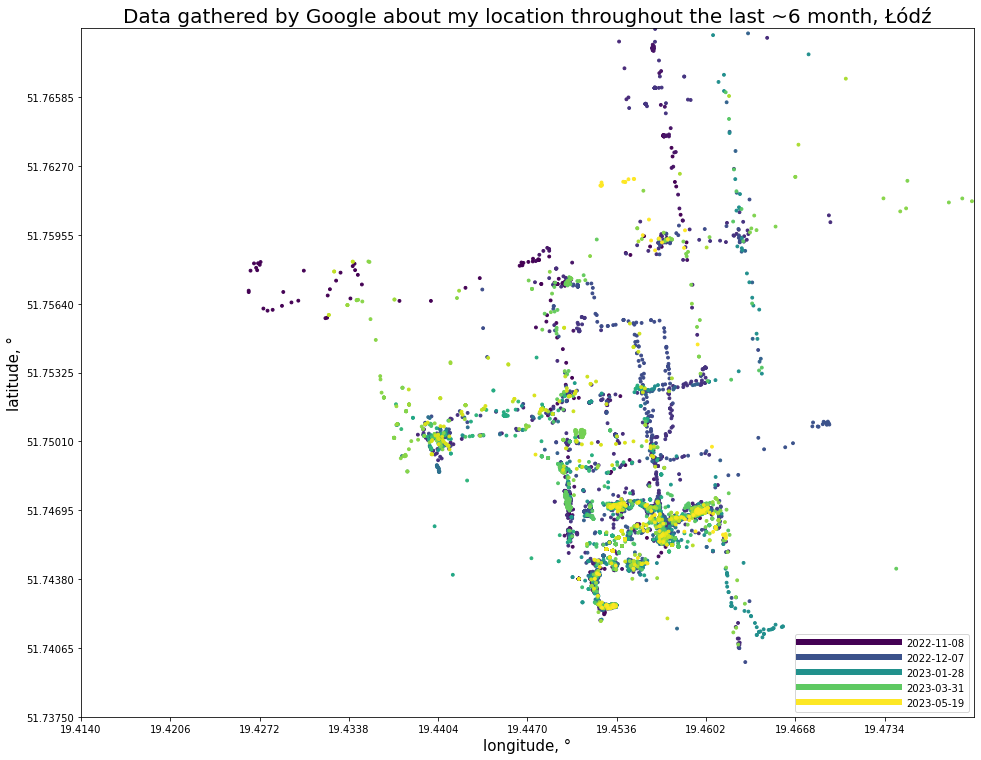

In [8]:
lodz_box = sg.box(19.414, 51.7375, 19.480, 51.7690)
draw_map(df, lodz_box, "Data gathered by Google about my location throughout the last ~6 month, Łódź")

# Statistics
## How many times has Google saved my location on specific days?

In [9]:
##capture
def datetime_to_date(pd_datatime_object):
    """Transform the date for easier representation in graphs"""
    return pd_datatime_object.date()

def aggregate_by(df, function):
    """Return a dataframe of activities and their number of observations on a given day"""
    tuples = []
    for activity in df.activity.unique():
        timestamp_in_dates = df.timestamp.apply(datetime_to_date)
        tuples.append((activity, df[df.activity == activity].groupby(timestamp_in_dates).activity.count()))
    
    return pd.DataFrame(dict(tuples))

Text(0, 0.5, 'Number of observations')

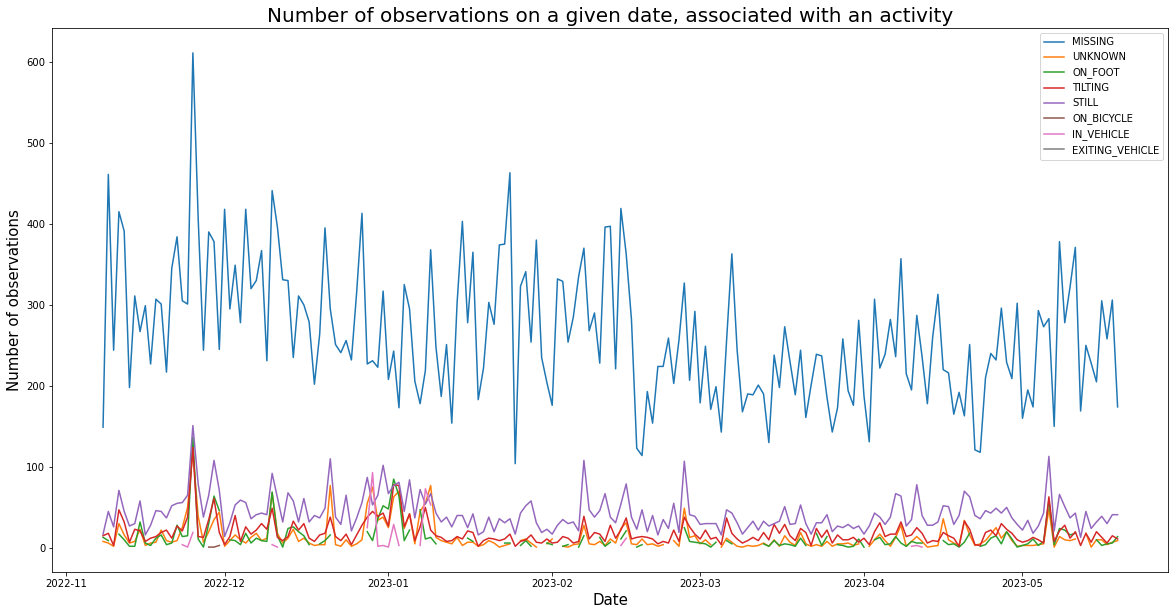

In [10]:
by_day = aggregate_by(df, datetime_to_date)
ax = by_day.plot(figsize=[20,10])
ax.set_title("Number of observations on a given date, associated with an activity", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Number of observations", fontsize=15)

## Most observed day, for some reason

In [11]:
by_day.loc[by_day.MISSING > 500]

,MISSING,UNKNOWN,ON_FOOT,TILTING,STILL,ON_BICYCLE,IN_VEHICLE,EXITING_VEHICLE
timestamp,,,,,,,,
2022-11-25,611,118.0,137.0,124,151,NaN,19.0,NaN


In [12]:
most_observations_date = df[df.timestamp.apply(datetime_to_date) == dt.date(2022, 11, 25)]

Text(0, 0.5, 'Observations, N')

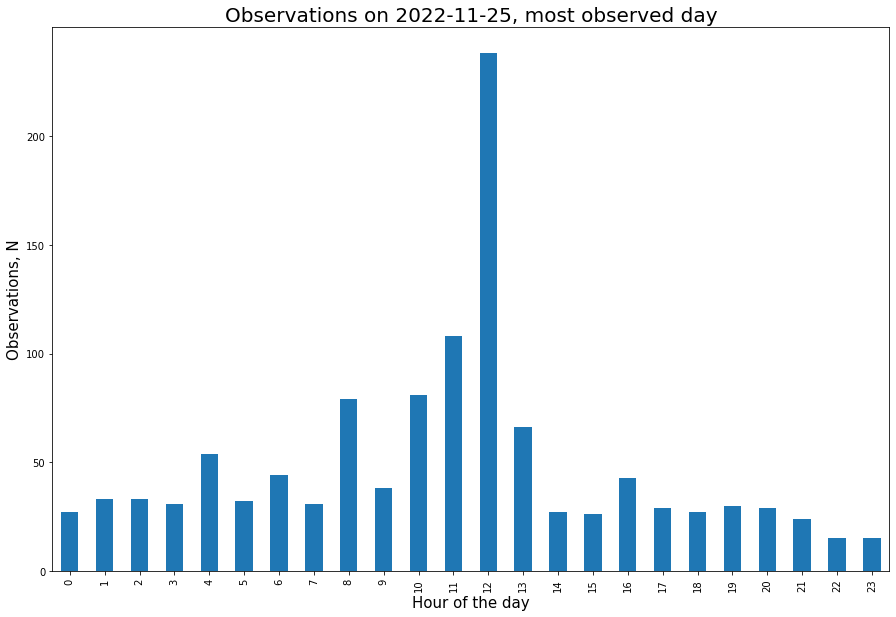

In [13]:
observation_by_the_hour = most_observations_date.groupby(df.timestamp.dt.hour)
ax = observation_by_the_hour.count().geometry.plot.bar(figsize=(15,10))
ax.set_title("Observations on 2022-11-25, most observed day", fontsize=20)
ax.set_xlabel("Hour of the day", fontsize=15)
ax.set_ylabel("Observations, N", fontsize=15)

## Histogram of altitudes on which I've been, logarithmic scale

Text(0.5, 0, 'Altitude')

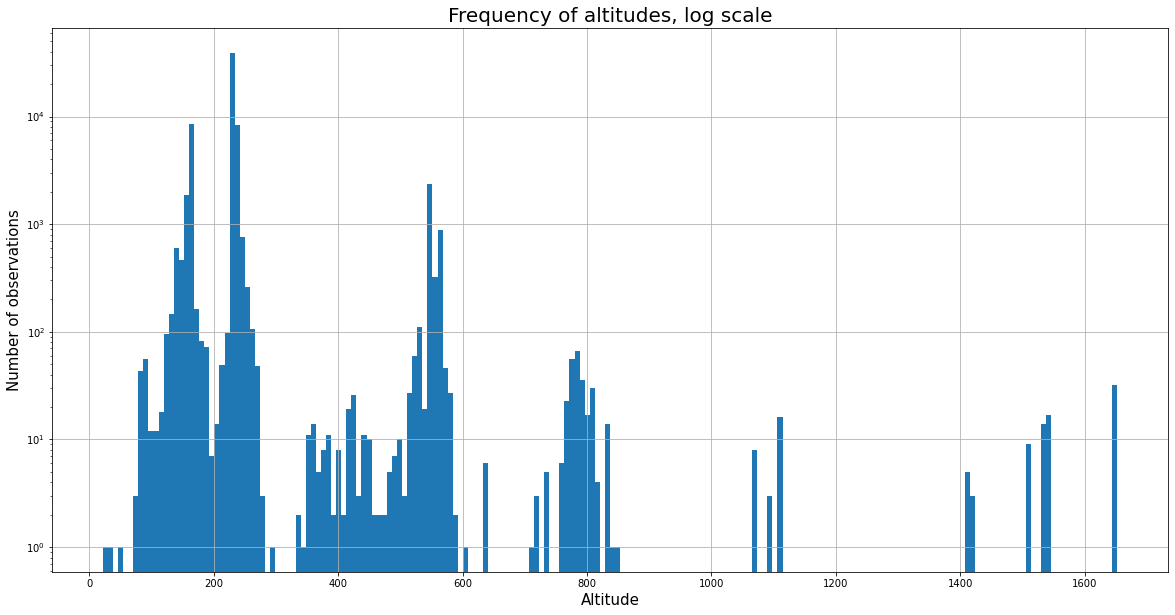

In [14]:
df = df.drop(df[df.altitude > 6000].index)  # drop several outliners
ax = df.altitude.hist(figsize=(20,10), bins=200, log=True)
ax.set_title("Frequency of altitudes, log scale", fontsize=20)
ax.set_ylabel("Number of observations", fontsize=15)
ax.set_xlabel("Altitude", fontsize=15)

## Highest altitude by date

Text(0.5, 0, 'Date')

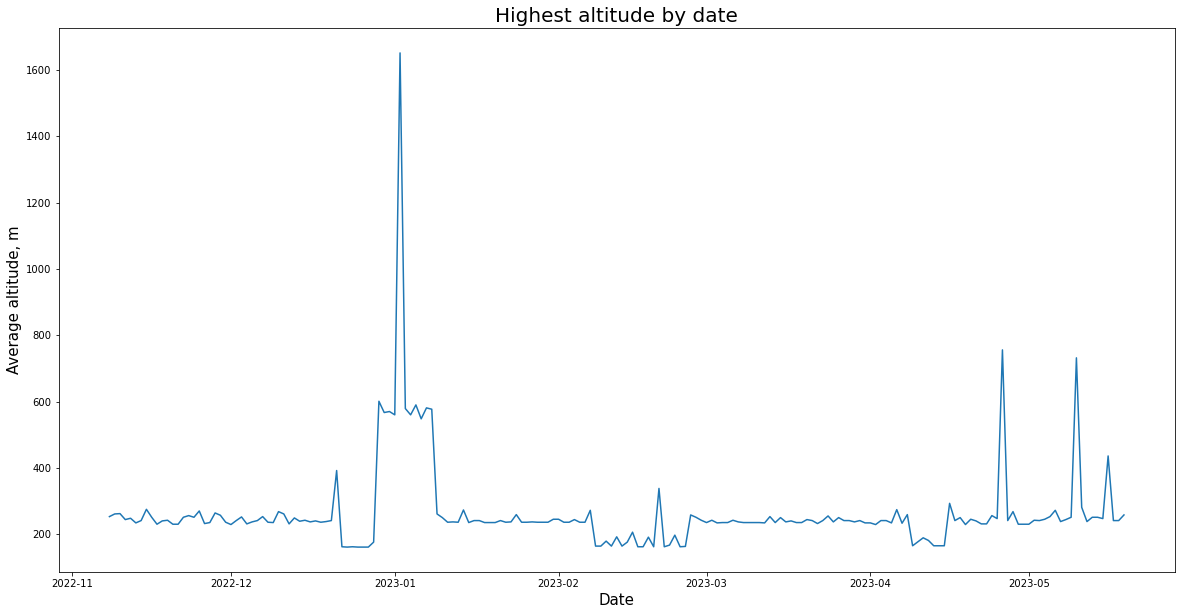

In [15]:
mean_altitudes = df.groupby(df.timestamp.apply(datetime_to_date)).altitude.max()
ax = mean_altitudes.plot(figsize=(20, 10))
ax.set_title("Highest altitude by date", fontsize=20)
ax.set_ylabel("Average altitude, m", fontsize=15)
ax.set_xlabel("Date", fontsize=15)